# 1. Data import

## 1.1 Importing the dataframes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
import math as math
from scipy import stats
import importlib
import project_functions

Here, we import functions we created in a previous notebook, so we can clean / reformat the column headers

In [2]:
importlib.reload(project_functions)

<module 'project_functions' from 'c:\\Users\\Carlos\\Desktop\\Vanguard-AB-Testing\\project_functions.py'>

In [3]:
# cleaning the columns : changing the columns headers to correct format
# for more information about this function --> cf project_functions.py notebook
clean_my_columns = project_functions.clean_my_columns

Now, we 'instance' our dataframes so we precise to Python to read them:

In [4]:
# Cargar el dataset demografic
df_pt1 = pd.read_csv('raw_data/df_final_web_data_pt_1.txt')
df_pt2 = pd.read_csv('raw_data/df_final_web_data_pt_2.txt')
df_users = pd.read_csv('raw_data/df_final_demo.txt')
df_exp =pd.read_csv('raw_data/df_final_experiment_clients.txt')

We apply column titles cleaning to every dataframe

In [5]:
clean_my_columns(df_exp)

clean_my_columns(df_users)

clean_my_columns(df_pt1)

clean_my_columns(df_pt2)

,client_id,visitor_id,visit_id,process_step,date_time
0,763412,601952081_10457207388,397475557_40440946728_419634,confirm,2017-06-06 08:56:00
1,6019349,442094451_91531546617,154620534_35331068705_522317,confirm,2017-06-01 11:59:27
2,6019349,442094451_91531546617,154620534_35331068705_522317,step_3,2017-06-01 11:58:48
3,6019349,442094451_91531546617,154620534_35331068705_522317,step_2,2017-06-01 11:58:08
4,6019349,442094451_91531546617,154620534_35331068705_522317,step_1,2017-06-01 11:57:58
...,...,...,...,...,...
412259,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:46:10
412260,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:45:29
412261,9668240,388766751_9038881013,922267647_3096648104_968866,step_1,2017-05-24 18:44:51
412262,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:44:34


## 1.2 Looking at the datraframes

### 1.2.0 Info about DF's

In [6]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70609 entries, 0 to 70608
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         70609 non-null  int64  
 1   clnt_tenure_yr    70595 non-null  float64
 2   clnt_tenure_mnth  70595 non-null  float64
 3   clnt_age          70594 non-null  float64
 4   gendr             70595 non-null  object 
 5   num_accts         70595 non-null  float64
 6   bal               70595 non-null  float64
 7   calls_6_mnth      70595 non-null  float64
 8   logons_6_mnth     70595 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 4.8+ MB


In [7]:
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70609 entries, 0 to 70608
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  70609 non-null  int64 
 1   variation  50500 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [8]:
df_pt1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343141 entries, 0 to 343140
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   client_id     343141 non-null  int64 
 1   visitor_id    343141 non-null  object
 2   visit_id      343141 non-null  object
 3   process_step  343141 non-null  object
 4   date_time     343141 non-null  object
dtypes: int64(1), object(4)
memory usage: 13.1+ MB


In [9]:
df_pt2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412264 entries, 0 to 412263
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   client_id     412264 non-null  int64 
 1   visitor_id    412264 non-null  object
 2   visit_id      412264 non-null  object
 3   process_step  412264 non-null  object
 4   date_time     412264 non-null  object
dtypes: int64(1), object(4)
memory usage: 15.7+ MB


### 1.2.1 DF "experiment participation"

The exp dataframe states whether a client (client_id) is being redirected on the original version (control) or to the new version (test)

In [10]:
display(df_exp)
df_exp.shape

,client_id,variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control
...,...,...
70604,2443347,NaN
70605,8788427,NaN
70606,266828,NaN
70607,1266421,NaN


(70609, 2)

### 1.2.2 DF "Clients' Demographic"

In [11]:
display(df_users)
df_users.shape

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0
...,...,...,...,...,...,...,...,...,...
70604,7993686,4.0,56.0,38.5,U,3.0,1411062.68,5.0,5.0
70605,8981690,12.0,148.0,31.0,M,2.0,101867.07,6.0,6.0
70606,333913,16.0,198.0,61.5,F,2.0,40745.00,3.0,3.0
70607,1573142,21.0,255.0,68.0,M,3.0,475114.69,4.0,4.0


(70609, 9)

### 1.2.3 "Footprints Data" - 2 Tables

In [12]:
display(df_pt1.head())
df_pt1.shape

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


(343141, 5)

In [13]:
display(df_pt2.head())
df_pt2.shape

,client_id,visitor_id,visit_id,process_step,date_time
0,763412,601952081_10457207388,397475557_40440946728_419634,confirm,2017-06-06 08:56:00
1,6019349,442094451_91531546617,154620534_35331068705_522317,confirm,2017-06-01 11:59:27
2,6019349,442094451_91531546617,154620534_35331068705_522317,step_3,2017-06-01 11:58:48
3,6019349,442094451_91531546617,154620534_35331068705_522317,step_2,2017-06-01 11:58:08
4,6019349,442094451_91531546617,154620534_35331068705_522317,step_1,2017-06-01 11:57:58


(412264, 5)

## 1.3 Combining tables

We're combining both group of tabless due to we have the same data columns within them.

### 1.3.1 Combining Footprints Tables:

In [14]:
# Combining df_pt_1 and df_pt_2:
df_footprint=pd.concat([df_pt1,df_pt2])

In [15]:
#Now we take a overview about the concatenated table
display(df_footprint.head())

print(f"shape of pt1: {df_pt1.shape}")
print(f"shape of pt2: {df_pt2.shape}")
print(f"shape of the concat: {df_footprint.shape}")

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


shape of pt1: (343141, 5)
shape of pt2: (412264, 5)
shape of the concat: (755405, 5)


Let's see how many unique clients we have data.

In [16]:
# Number of clients
df_footprint['client_id'].nunique()

120157

### 1.3.2 Combining Demo and Experiment tables

Experiment a demo tables have the exactly same shape and they have client_id in common, soy we are going to merge them to have the second column from experiment as another variable in our big table "demographics". 

In [17]:
df_clients = df_users.merge(df_exp, on='client_id', how='left')

In [18]:
df_clients = df_clients.reset_index(drop=True)

In [19]:
display(df_clients)
df_clients.shape

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,variation
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0,Test
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0,Control
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0,Test
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0,Test
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0,Control
...,...,...,...,...,...,...,...,...,...,...
70604,7993686,4.0,56.0,38.5,U,3.0,1411062.68,5.0,5.0,NaN
70605,8981690,12.0,148.0,31.0,M,2.0,101867.07,6.0,6.0,NaN
70606,333913,16.0,198.0,61.5,F,2.0,40745.00,3.0,3.0,NaN
70607,1573142,21.0,255.0,68.0,M,3.0,475114.69,4.0,4.0,NaN


(70609, 10)

# 2. Cleaning Dataframes

## 2.1 Cleaning Clients Table

### 2.1.1 Duplicates

In [20]:
# Let's check how many duplicated rows there are.
duplicates_clients = df_clients.duplicated(keep=False)
df_duplicates_clients = df_clients[duplicates_clients]

print(df_duplicates_clients)

Empty DataFrame
Columns: [client_id, clnt_tenure_yr, clnt_tenure_mnth, clnt_age, gendr, num_accts, bal, calls_6_mnth, logons_6_mnth, variation]
Index: []


In [21]:
# Deleting all duplicates
df_clients_nd = df_clients.drop_duplicates(keep=False)

print(df_clients_nd)

       client_id  clnt_tenure_yr  clnt_tenure_mnth  clnt_age gendr  num_accts  \
0         836976             6.0              73.0      60.5     U        2.0   
1        2304905             7.0              94.0      58.0     U        2.0   
2        1439522             5.0              64.0      32.0     U        2.0   
3        1562045            16.0             198.0      49.0     M        2.0   
4        5126305            12.0             145.0      33.0     F        2.0   
...          ...             ...               ...       ...   ...        ...   
70604    7993686             4.0              56.0      38.5     U        3.0   
70605    8981690            12.0             148.0      31.0     M        2.0   
70606     333913            16.0             198.0      61.5     F        2.0   
70607    1573142            21.0             255.0      68.0     M        3.0   
70608    5602139            21.0             254.0      59.5     F        3.0   

              bal  calls_6_

### 2.1.2 Nulls

In [22]:
missing_clients_data = df_clients_nd.isnull().sum()
print(missing_clients_data)

client_id               0
clnt_tenure_yr         14
clnt_tenure_mnth       14
clnt_age               15
gendr                  14
num_accts              14
bal                    14
calls_6_mnth           14
logons_6_mnth          14
variation           20109
dtype: int64


We procced to drop rows with nulls data (20109 rows)

In [23]:
df_clients_nd_nn = df_clients_nd.dropna()

print(df_clients_nd_nn)

       client_id  clnt_tenure_yr  clnt_tenure_mnth  clnt_age gendr  num_accts  \
0         836976             6.0              73.0      60.5     U        2.0   
1        2304905             7.0              94.0      58.0     U        2.0   
2        1439522             5.0              64.0      32.0     U        2.0   
3        1562045            16.0             198.0      49.0     M        2.0   
4        5126305            12.0             145.0      33.0     F        2.0   
...          ...             ...               ...       ...   ...        ...   
50495    1780858            21.0             262.0      68.5     M        3.0   
50496    6967120            21.0             260.0      68.5     M        3.0   
50497    5826160            20.0             249.0      56.5     F        2.0   
50498    8739285            19.0             229.0      69.5     F        2.0   
50499    7468138            18.0             222.0      61.0     F        3.0   

              bal  calls_6_

### 2.1.3 Column client_id

* Checking unique values

In [24]:
df_clients_nd_nn.shape

(50487, 10)

In [25]:
df_clients_nd_nn['client_id'].nunique()

50487

Unique values for id_client is the same than shape, so we assume it is cleaned.

### 2.1.4 Column clnt_tenure_yr

In [26]:
display(df_clients_nd_nn['clnt_tenure_yr'])
print(f"Valor mínimo: {df_clients_nd_nn['clnt_tenure_yr'].min()}")
print(f"Valor mínimo: {df_clients_nd_nn['clnt_tenure_yr'].max()}")

0         6.0
1         7.0
2         5.0
3        16.0
4        12.0
         ... 
50495    21.0
50496    21.0
50497    20.0
50498    19.0
50499    18.0
Name: clnt_tenure_yr, Length: 50487, dtype: float64

Valor mínimo: 2.0
Valor mínimo: 55.0


We change the column datatype:

In [27]:
df_clients_nd_nn['clnt_tenure_yr'] = df_clients_nd_nn['clnt_tenure_yr'].astype(int)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_27420\2219402206.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clients_nd_nn['clnt_tenure_yr'] = df_clients_nd_nn['clnt_tenure_yr'].astype(int)


In [28]:
df_clients_nd_nn['clnt_tenure_yr'].unique()

array([ 6,  7,  5, 16, 12, 30, 15,  8,  4,  3, 10, 11, 13, 14, 19, 18, 25,
       23, 21, 17,  9, 27, 24, 20, 28, 22, 29, 46, 26, 32, 33, 35,  2, 38,
       31, 48, 34, 36, 51, 47, 49, 37, 39, 40, 55, 42, 44, 43, 50, 54, 41,
       45, 52])

### 2.1.5 Column clnt_tenure_mnth

In [29]:
display(df_clients_nd_nn['clnt_tenure_yr'])
print(f"Valor mínimo: {df_clients_nd_nn['clnt_tenure_yr'].min()}")
print(f"Valor mínimo: {df_clients_nd_nn['clnt_tenure_yr'].max()}")

0         6
1         7
2         5
3        16
4        12
         ..
50495    21
50496    21
50497    20
50498    19
50499    18
Name: clnt_tenure_yr, Length: 50487, dtype: int32

Valor mínimo: 2
Valor mínimo: 55


We change the column datatype:

In [30]:
df_clients_nd_nn['clnt_tenure_mnth'] = df_clients_nd_nn['clnt_tenure_mnth'].astype(int)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_27420\143528322.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clients_nd_nn['clnt_tenure_mnth'] = df_clients_nd_nn['clnt_tenure_mnth'].astype(int)


In [31]:
df_clients_nd_nn['clnt_tenure_mnth'].unique()

array([ 73,  94,  64, 198, 145,  71,  66, 361, 369, 189, 100,  99,  67,
       193,  58,  47, 122, 136, 101, 103,  70, 152, 160,  80,  88,  86,
        65,  68,  93,  85, 168, 142, 228, 223, 305, 286, 285, 280, 254,
       253, 278, 221, 216, 212, 204, 260, 116, 130, 177, 159, 190,  89,
        91, 129, 329,  92,  82, 169, 239,  69, 178,  95,  63, 187, 288,
       261, 251, 250,  56,  60, 123, 175, 188,  59, 336, 149, 156, 330,
       155, 167,  96, 242, 163,  81, 182, 134, 113, 172, 120, 105, 271,
       244, 200, 157,  78, 151, 121, 184, 335, 357, 111, 185,  76, 148,
        97,  83, 347, 324, 162, 194,  74, 186, 300, 289, 295, 282, 270,
       246, 229, 206, 109, 343, 176, 144, 161, 179, 106, 154, 119,  75,
       166, 143, 202, 326, 298, 290, 279, 252,  57, 334, 150,  46, 114,
       174,  72, 107, 164, 131, 554, 140, 118, 292, 273, 257, 225, 128,
       135, 258, 126, 359, 210, 263, 262, 255, 214, 310, 141, 319, 395,
       108, 181, 173,  55, 203, 297, 213, 183, 115, 117, 299, 28

Let's see if moonths and years of tenure are coherent. 

In [32]:
# Comprobamos si hay filas donde los meses son mayores o iguales a 12 pero no coinciden con los años
df_inconsistencias = df_clients_nd_nn[(df_clients_nd_nn['clnt_tenure_mnth'] >= 12) & (df_clients_nd_nn['clnt_tenure_yr'] != df_clients_nd_nn['clnt_tenure_mnth'] // 12)]

# Mostrar filas con inconsistencias
print(df_inconsistencias)

       client_id  clnt_tenure_yr  clnt_tenure_mnth  clnt_age gendr  num_accts  \
113      7045562               7                96      33.5     U        3.0   
1035     6895833               7                96      58.5     U        2.0   
1529     6915261              11               144      46.0     F        2.0   
1648      911208              11               144      34.5     M        2.0   
1703      346409              15               192      48.5     M        2.0   
2196     3071537               3                48      31.5     U        2.0   
12235    1114136              15               192      60.0     M        3.0   
13343    7041735              11               144      22.5     F        2.0   
16310    7479669              23               288      75.0     M        3.0   
23813    2798244               7                96      33.5     U        2.0   
24424    1230061              15               192      51.0     M        2.0   
24793    8996903            

Let's drop that inconsistences:

In [33]:
df_clients_nd_nn_in = df_clients_nd_nn.drop(df_inconsistencias.index)

### 2.1.6 Column client_age

In [34]:
display(df_clients_nd_nn_in['clnt_age'])
print(f"Valor mínimo: {df_clients_nd_nn_in['clnt_age'].min()}")
print(f"Valor máximo: {df_clients_nd_nn_in['clnt_age'].max()}")

0        60.5
1        58.0
2        32.0
3        49.0
4        33.0
         ... 
50495    68.5
50496    68.5
50497    56.5
50498    69.5
50499    61.0
Name: clnt_age, Length: 50456, dtype: float64

Valor mínimo: 17.0
Valor máximo: 96.0


We round the client's age.We add the column.

In [35]:
df_clients_nd_nn_in['edad_redondeada'] = df_clients_nd_nn_in['clnt_age'].round()

And we assign to rounded_aged a int datatype

In [36]:
df_clients_nd_nn_in['edad_redondeada'] = df_clients_nd_nn_in['edad_redondeada'].astype(int)

Let's graph ages

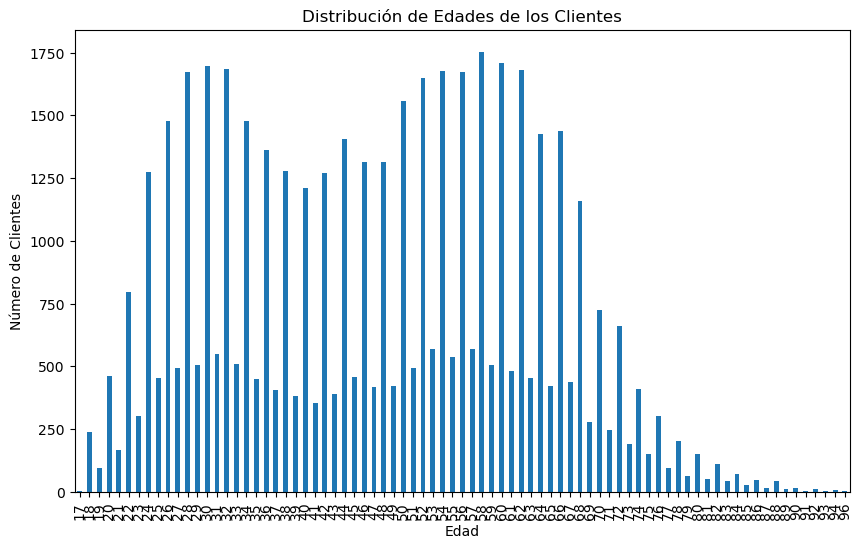

In [37]:
# Supongamos que tu DataFrame tiene una columna llamada 'edad'
df_clients_nd_nn_in['edad_redondeada'].value_counts().sort_index().plot(kind='bar', figsize=(10,6))

# Añadir título y etiquetas
plt.title('Distribución de Edades de los Clientes')
plt.xlabel('Edad')
plt.ylabel('Número de Clientes')

# Mostrar el gráfico
plt.show()

### 2.1.7 Column gender

In [38]:
display(df_clients_nd_nn_in['gendr'])
print(f"Valor mínimo: {df_clients_nd_nn_in['gendr'].min()}")
print(f"Valor máximo: {df_clients_nd_nn_in['gendr'].max()}")

0        U
1        U
2        U
3        M
4        F
        ..
50495    M
50496    M
50497    F
50498    F
50499    F
Name: gendr, Length: 50456, dtype: object

Valor mínimo: F
Valor máximo: X


Check unique values

In [39]:
unique_genders = df_clients_nd_nn_in['gendr'].unique()
count_genders = df_clients_nd_nn_in['gendr'].value_counts()
print("\nValores únicos en la columna 'gendr':")
print(unique_genders)
print(count_genders)


Valores únicos en la columna 'gendr':
['U' 'M' 'F' 'X']
gendr
U    17266
M    16936
F    16252
X        2
Name: count, dtype: int64


Let's replace X by U in those 2 values with X gender. 

In [40]:
df_clients_nd_nn_in['gendr'] = df_clients_nd_nn_in['gendr'].replace('X', 'U')

In [41]:
# In case you wannna drop those.
# df_clients_nd_nn_in_gdr = df_clients_nd_nn_in[df_clients_nd_nn_in['gendr'] != 'X']

### 2.1.8 Column num_accts

In [42]:
display(df_clients_nd_nn_in['num_accts'])
print(f"Valor mínimo: {df_clients_nd_nn_in['num_accts'].min()}")
print(f"Valor máximo: {df_clients_nd_nn_in['num_accts'].max()}")

0        2.0
1        2.0
2        2.0
3        2.0
4        2.0
        ... 
50495    3.0
50496    3.0
50497    2.0
50498    2.0
50499    3.0
Name: num_accts, Length: 50456, dtype: float64

Valor mínimo: 1.0
Valor máximo: 7.0


We change the column datatype:

In [43]:
df_clients_nd_nn_in['num_accts'] = df_clients_nd_nn_in['num_accts'].astype(int)

In [44]:
df_clients_nd_nn_in['num_accts'].value_counts()

num_accts
2    39700
3     8937
4     1585
5      204
6       23
7        6
1        1
Name: count, dtype: int64

### 2.1.9 Column bal

In [69]:
display(df_clients_nd_nn_in['bal'])
print(f"Valor mínimo: {df_clients_nd_nn_in['bal'].min()}")
print(f"Valor máximo: {df_clients_nd_nn_in['bal'].max()}")

0          45105.30
1         110860.30
2          52467.79
3          67454.65
4         103671.75
            ...    
50451     372100.59
50452    4279873.38
50453      44837.16
50454      44994.24
50455     209278.15
Name: bal, Length: 50456, dtype: float64

Valor mínimo: 23789.44
Valor máximo: 16320040.15


In [70]:
df_clients_nd_nn_in['bal'].value_counts()

bal
31188.62     5
29388.51     4
29388.50     3
29389.11     3
31398.74     3
            ..
638185.61    1
100935.57    1
123195.34    1
85567.13     1
209278.15    1
Name: count, Length: 50281, dtype: int64

### 2.1.10 Column calls_6_month

In [47]:
display(df_clients_nd_nn_in['calls_6_mnth'])
print(f"Valor mínimo: {df_clients_nd_nn_in['calls_6_mnth'].min()}")
print(f"Valor máximo: {df_clients_nd_nn_in['calls_6_mnth'].max()}")

0        6.0
1        6.0
2        6.0
3        3.0
4        0.0
        ... 
50495    6.0
50496    6.0
50497    2.0
50498    1.0
50499    0.0
Name: calls_6_mnth, Length: 50456, dtype: float64

Valor mínimo: 0.0
Valor máximo: 6.0


In [48]:
df_clients_nd_nn_in['calls_6_mnth'].value_counts()

calls_6_mnth
6.0    12215
1.0     7904
0.0     7727
2.0     7210
3.0     5850
4.0     4844
5.0     4706
Name: count, dtype: int64

Let's turn into int

In [49]:
df_clients_nd_nn_in['calls_6_mnth'] = df_clients_nd_nn_in['calls_6_mnth'].astype(int)

### 2.1.11 Column logons_6_mnth

In [50]:
display(df_clients_nd_nn_in['logons_6_mnth'])
print(f"Valor mínimo: {df_clients_nd_nn_in['logons_6_mnth'].min()}")
print(f"Valor máximo: {df_clients_nd_nn_in['logons_6_mnth'].max()}")

0        9.0
1        9.0
2        9.0
3        6.0
4        3.0
        ... 
50495    9.0
50496    9.0
50497    5.0
50498    4.0
50499    3.0
Name: logons_6_mnth, Length: 50456, dtype: float64

Valor mínimo: 3.0
Valor máximo: 9.0


In [51]:
df_clients_nd_nn_in['logons_6_mnth'].value_counts()

logons_6_mnth
9.0    12340
4.0     7851
3.0     7306
5.0     7278
6.0     5962
7.0     4910
8.0     4809
Name: count, dtype: int64

In [52]:
df_clients_nd_nn_in['logons_6_mnth'] = df_clients_nd_nn_in['logons_6_mnth'].astype(int)

### 2.1.12 Restart the index

In [53]:
df_clients_nd_nn_in = df_clients_nd_nn_in.reset_index(drop=True)

## 2.2 Cleaning Footprints Table

### 2.2.1 Duplicates

In [54]:
# Let's check how many duplicated rows there are.
duplicates = df_footprint.duplicated(keep=False)
df_duplicates = df_footprint[duplicates]

print(df_duplicates)

        client_id             visitor_id                      visit_id  \
364       9358626  148475529_63668223960  223297395_36250329195_832161   
365       9358626  148475529_63668223960  223297395_36250329195_832161   
367       5376894  622509328_44408201172  688984457_43441834354_912755   
368       5376894  622509328_44408201172  688984457_43441834354_912755   
382        438567  923318467_50708963627  330543236_29863358529_771432   
...           ...                    ...                           ...   
412165    4408245   14058946_73585431797  994148957_84373994761_991865   
412166    4408245   14058946_73585431797  994148957_84373994761_991865   
412167    4408245   14058946_73585431797  994148957_84373994761_991865   
412216    3897324   80177429_24869309091  149796456_64325617570_112561   
412217    3897324   80177429_24869309091  149796456_64325617570_112561   

       process_step            date_time  
364           start  2017-04-28 12:27:28  
365           start  2017

In [55]:
# Deleting all duplicates
df_footprint_nd = df_footprint.drop_duplicates(keep=False)

print(df_footprint_nd)

        client_id             visitor_id                      visit_id  \
0         9988021   580560515_7732621733  781255054_21935453173_531117   
1         9988021   580560515_7732621733  781255054_21935453173_531117   
2         9988021   580560515_7732621733  781255054_21935453173_531117   
3         9988021   580560515_7732621733  781255054_21935453173_531117   
4         9988021   580560515_7732621733  781255054_21935453173_531117   
...           ...                    ...                           ...   
412259    9668240   388766751_9038881013   922267647_3096648104_968866   
412260    9668240   388766751_9038881013   922267647_3096648104_968866   
412261    9668240   388766751_9038881013   922267647_3096648104_968866   
412262    9668240   388766751_9038881013   922267647_3096648104_968866   
412263     674799  947159805_81558194550   86152093_47511127657_716022   

       process_step            date_time  
0            step_3  2017-04-17 15:27:07  
1            step_2  2017

### 2.2.2 Drop Clients not in experiment

In [56]:
#create list of client_ids: 
clients_list = list(df_clients_nd_nn_in['client_id'])
clients_list

[836976,
 2304905,
 1439522,
 1562045,
 5126305,
 3727881,
 272934,
 388801,
 285619,
 8198645,
 8368822,
 2537139,
 2208717,
 2214073,
 2368987,
 2892152,
 4536541,
 3788589,
 719792,
 5904035,
 1502049,
 6590646,
 7585111,
 3638336,
 9520009,
 1508759,
 9381346,
 7035604,
 3055315,
 3350906,
 2109862,
 1549737,
 7474517,
 6448014,
 6651826,
 2305285,
 5889920,
 3065089,
 313570,
 9721424,
 3753796,
 6647577,
 6341488,
 838619,
 2000151,
 6579978,
 8475126,
 7419744,
 9796602,
 1329260,
 4821014,
 7906602,
 2671231,
 9587439,
 5542798,
 5977906,
 7928244,
 4906392,
 3939684,
 3731320,
 9055726,
 5808972,
 7414763,
 1531616,
 8387066,
 3402999,
 8593187,
 5908339,
 4442018,
 5727622,
 3284361,
 6666515,
 9150149,
 7176877,
 410752,
 3979917,
 7759130,
 5587497,
 4264493,
 9492169,
 5816825,
 9692048,
 9250552,
 1730954,
 2264903,
 7321667,
 1460648,
 2942135,
 1459001,
 6398341,
 5531076,
 3162487,
 2570380,
 5449775,
 8415669,
 6810931,
 8096768,
 6737425,
 7949341,
 7458635,
 3322068

Because we need to put an eye only in the clients who we know are in the experiment (so, the list of clients in df_clients), we are deleting the rest of clients. 

In [57]:
#creating new dataframe with footprints only with clients from clients list
df_sample_fp = df_footprint_nd.loc[df_footprint_nd['client_id'].isin(clients_list)]

df_sample_fp.shape

(313904, 5)

In [58]:
df_sample_fp = df_sample_fp.reset_index(drop=True)

### 2.2.3 Nulls

Let's see now if we have nulls values

In [59]:
missing_data = df_footprint_nd.isnull().sum()
print(missing_data)

client_id       0
visitor_id      0
visit_id        0
process_step    0
date_time       0
dtype: int64


# 3. Exporting our cleaned dataframes

Rename dataframes for easy exportation

In [60]:
df_clean_users = df_clients_nd_nn_in
df_clean_fp = df_footprint_nd

Exportation to CSV

In [61]:
df_clean_fp.to_csv('clean_data/df_clean_fp.csv', index=False)
df_clean_users.to_csv('clean_data/df_clean_users.csv', index=False)

# 4. Who are ours Clients

## 4.1 Primary Clients

### 4.1.1 By Gender

In [62]:
df_clean_users.groupby(['gendr'])['client_id'].count()

gendr
F    16252
M    16936
U    17268
Name: client_id, dtype: int64

<Axes: xlabel='gendr', ylabel='Count'>

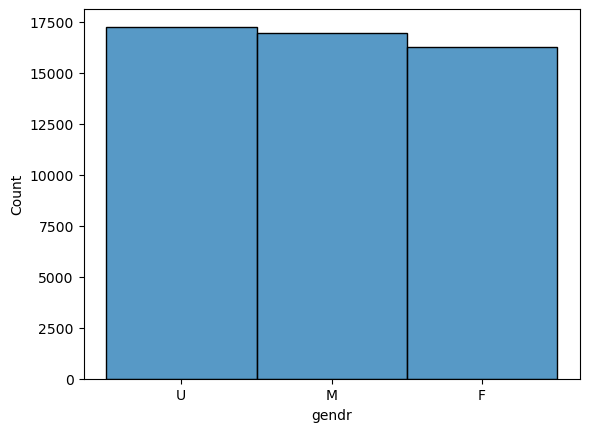

In [63]:
sns.histplot(df_clean_users, x="gendr")

### 4.1.2 Clients by Tenure

<Axes: xlabel='clnt_tenure_yr', ylabel='Count'>

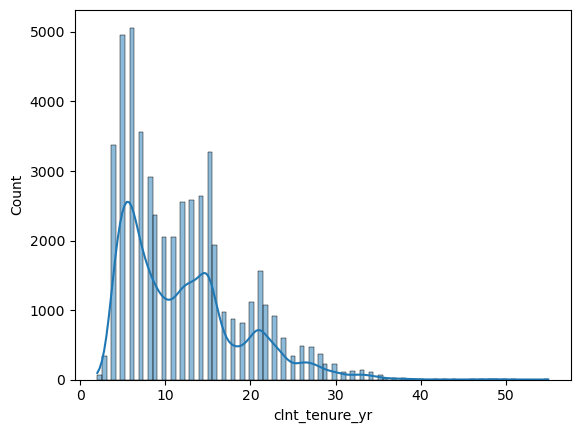

In [64]:
plt.figure()
#sns.histplot(df_sample_client, x="clnt_tenure_yr")
#kde keyword adds a line that represents the shape of the histogram
sns.histplot(df_clean_users, x="clnt_tenure_yr",kde=True)
#plt.figure(figsize=(10,10))

### 4.1.3 Clients by Age

<Axes: xlabel='clnt_age', ylabel='Count'>

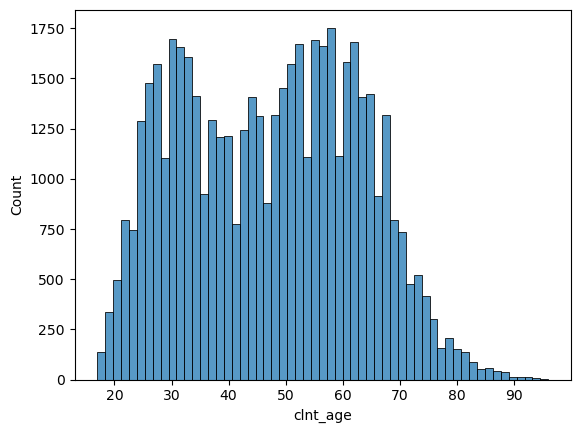

In [66]:
sns.histplot(df_clean_users, x="clnt_age")

<Axes: xlabel='edad_redondeada', ylabel='Count'>

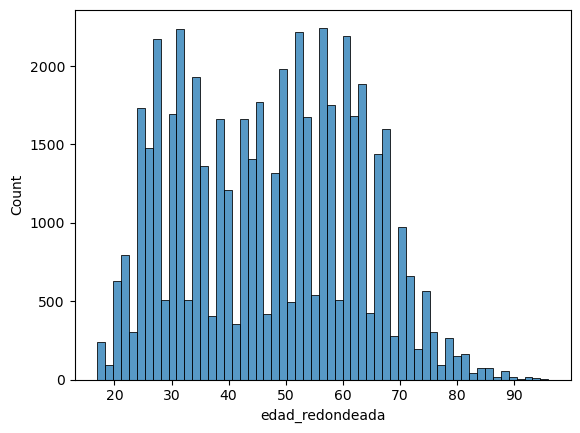

In [65]:
sns.histplot(df_clean_users, x="edad_redondeada")

### 4.1.4 Clients by owned accounts

In [67]:
df_clean_users.groupby(['num_accts'])['client_id'].count()

num_accts
1        1
2    39700
3     8937
4     1585
5      204
6       23
7        6
Name: client_id, dtype: int64

<Axes: xlabel='num_accts', ylabel='Count'>

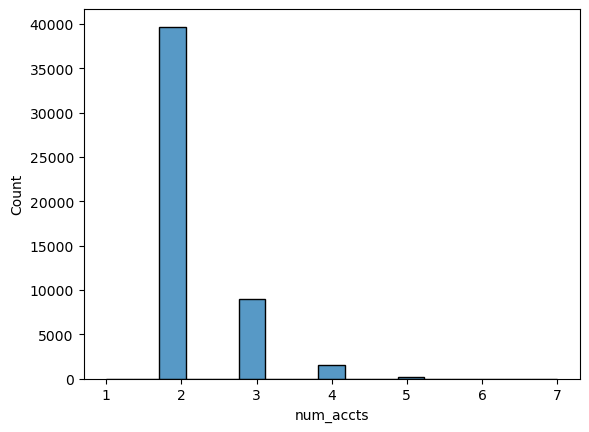

In [68]:
sns.histplot(df_clean_users, x="num_accts")

### 4.1.5 Clients by bal

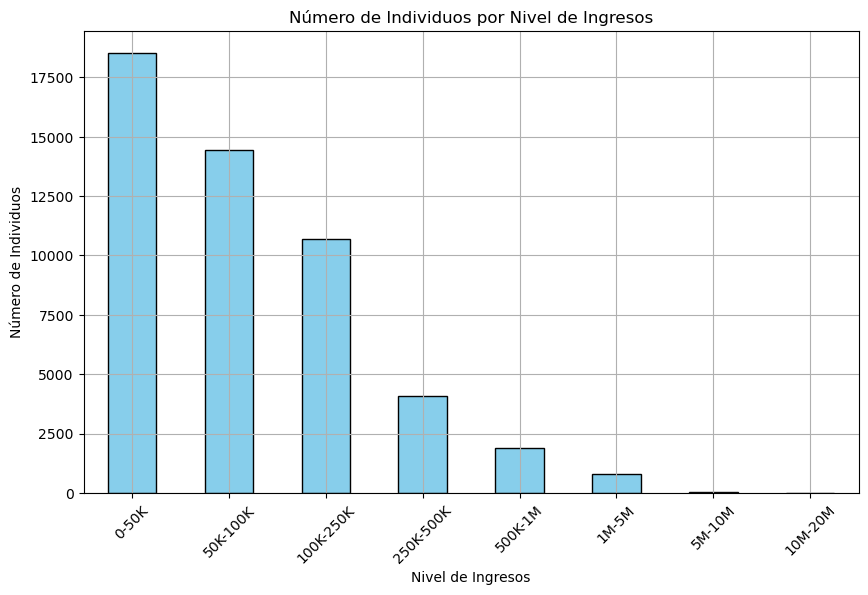

In [71]:
# Definir los límites de los grupos de ingresos
bins = [0, 50000, 100000, 250000, 500000, 1000000, 5000000, 10000000, 20000000]
labels = ['0-50K', '50K-100K', '100K-250K', '250K-500K', '500K-1M', '1M-5M', '5M-10M', '10M-20M']

# Crear una nueva columna con los grupos de ingresos
df_clean_users['full_bal'] = pd.cut(df_clean_users['bal'], bins=bins, labels=labels)

# Contar cuántos individuos hay en cada grupo
income_group_counts = df_clean_users['full_bal'].value_counts().sort_index()

# Graficar el número de individuos en cada grupo
plt.figure(figsize=(10, 6))
income_group_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Número de Individuos por Nivel de Ingresos')
plt.xlabel('Nivel de Ingresos')
plt.ylabel('Número de Individuos')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### 4.1.6 Clients by calls_6_mnth

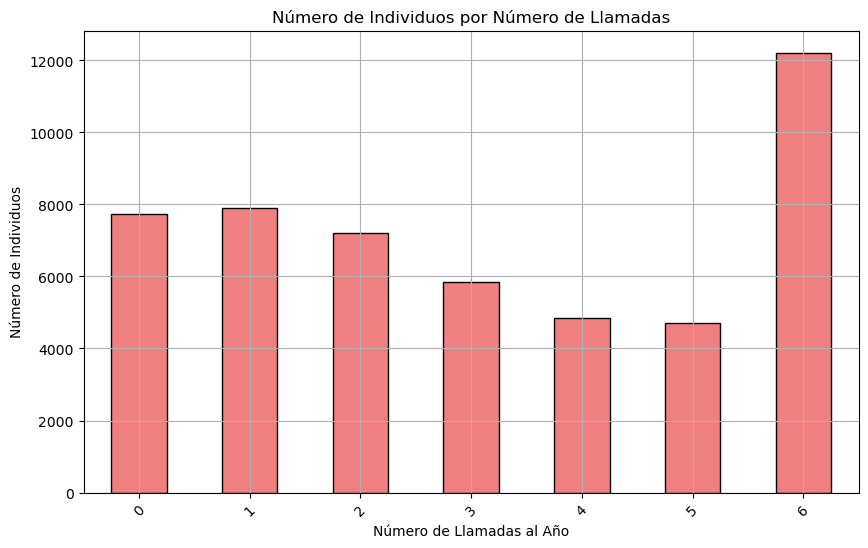

In [72]:
# Definir los límites de los grupos de llamadas
call_bins = [-1, 0, 1, 2, 3, 4, 5, 6]
call_labels = ['0','1', '2', '3', '4', '5', '6']

# Crear una nueva columna con los grupos de llamadas
df_clean_users['call_group'] = pd.cut(df_clean_users['calls_6_mnth'], bins=call_bins, labels=call_labels)

# Contar cuántos individuos hay en cada grupo de llamadas
call_group_counts = df_clean_users['call_group'].value_counts().sort_index()

# Graficar el número de individuos por grupo de llamadas
plt.figure(figsize=(10, 6))
call_group_counts.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Número de Individuos por Número de Llamadas')
plt.xlabel('Número de Llamadas al Año')
plt.ylabel('Número de Individuos')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### 4.1.7 Clients by logons_6_mnth

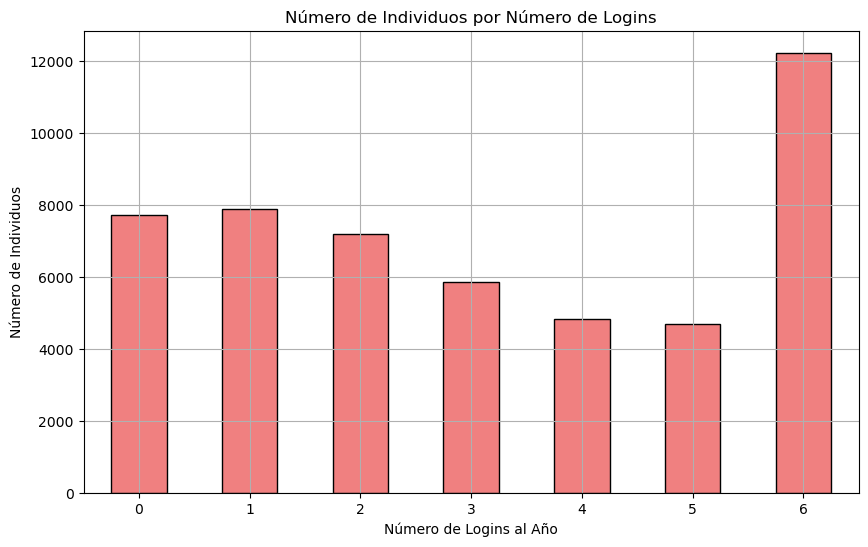

In [73]:
logins_group_counts = df_clean_users['logons_6_mnth'].value_counts().sort_index()

# Graficar el número de individuos por grupo de llamadas
plt.figure(figsize=(10, 6))
call_group_counts.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Número de Individuos por Número de Logins')
plt.xlabel('Número de Logins al Año')
plt.ylabel('Número de Individuos')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

### 4.1.8 Clients by Variation Used

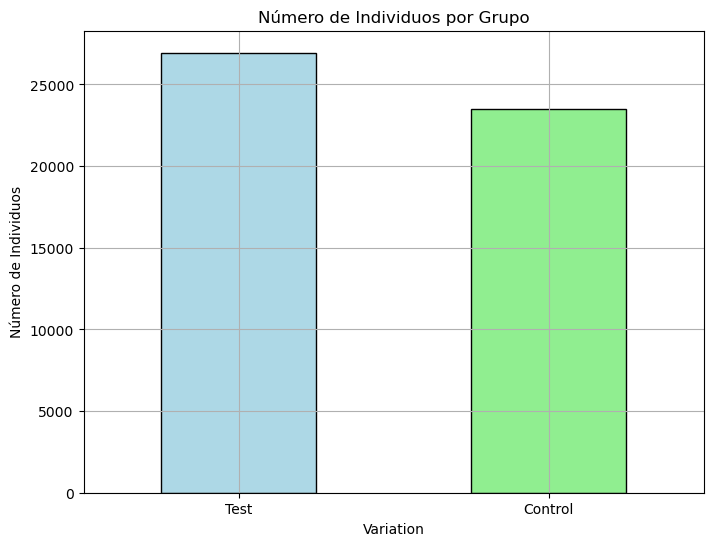

In [74]:
group_counts = df_clean_users['variation'].value_counts()
plt.figure(figsize=(8, 6))
group_counts.plot(kind='bar', color=['lightblue', 'lightgreen'], edgecolor='black')
plt.title('Número de Individuos por Grupo')
plt.xlabel('Variation')
plt.ylabel('Número de Individuos')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

In [65]:
df_clean_users.head(5)

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,variation,edad_redondeada
0,836976,6,73,60.5,U,2,45105.30,6,9,Test,60.0
1,2304905,7,94,58.0,U,2,110860.30,6,9,Control,58.0
2,1439522,5,64,32.0,U,2,52467.79,6,9,Test,32.0
3,1562045,16,198,49.0,M,2,67454.65,3,6,Test,49.0
4,5126305,12,145,33.0,F,2,103671.75,0,3,Control,33.0


# Para comprobar si hay datos atípicos en la columna clnt_age, puedes calcular los límites intercuartílicos (IQR). 

In [77]:
# Calcular Q1 (primer cuartil) y Q3 (tercer cuartil)
Q1 = df_demo['clnt_age'].quantile(0.25)
Q3 = df_demo['clnt_age'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites inferior y superior
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar valores atípicos
outliers = df_demo[(df_demo['clnt_age'] < lower_bound) | (df_demo['clnt_age'] > upper_bound)]

# Mostrar cantidad de valores atípicos
print(f'Cantidad de valores atípicos en clnt_age: {outliers.shape[0]}')


Cantidad de valores atípicos en clnt_age: 0


#  Análisis de la Demografía de los Clientes

In [ ]:
import pandas as pd

# Cargar el DataFrame (si no está cargado)
# df_demo = pd.read_csv('ruta_al_archivo.csv')

# Análisis de la edad de los clientes
age_distribution = df_demo['clnt_age'].describe()

# Distribución de género
gender_distribution = df_demo['gendr'].value_counts()

# Número de cuentas por cliente
account_distribution = df_demo['num_accts'].value_counts()

age_distribution, gender_distribution, account_distribution

In [ ]:
# Edad promedio
average_age = df_demo['clnt_age'].mean()

# Tenencia promedio
average_tenure = df_demo['clnt_tenure_yr'].mean()

# Agrupar por edad y tenencia
age_tenure_analysis = df_demo.groupby(['clnt_tenure_yr', 'clnt_age']).size().reset_index(name='counts')

average_age, average_tenure, age_tenure_analysis

In [ ]:
# Análisis de saldo en función de la edad
age_balance_correlation = df_demo[['clnt_age', 'bal']].corr()

# Promedio de llamadas y logins por grupo de saldo
call_login_analysis = df_demo.groupby(pd.cut(df_demo['bal'], bins=[0, 100000, 500000, 1000000, 10000000])).agg({'calls_6_mnth': 'mean', 'logons_6_mnth': 'mean'})

age_balance_correlation, call_login_analysis

In [ ]:
correlation_age_accounts = df_demo['clnt_age'].corr(df_demo['num_accts'])
print("Correlación entre Edad y Número de Cuentas:", correlation_age_accounts)

In [ ]:
age_bins = [0, 30, 45, 60, 100]
age_labels = ['Joven', 'Adulto', 'Mayor', 'Anciano']
df_demo['age_group'] = pd.cut(df_demo['clnt_age'], bins=age_bins, labels=age_labels)

avg_accounts_by_age_group = df_demo.groupby('age_group')['num_accts'].mean()
print(avg_accounts_by_age_group)

In [ ]:
demographics_balance = df_demo.groupby(['clnt_age', 'gendr'])['bal'].describe()
demographics_balance